In [14]:
import pandas as pd

# Replace 'your_clickbait_dataset.csv' with the path to your dataset
dataset = pd.read_csv('clickbait_data.csv')

# Turn the clickbait column into a boolean column
dataset['clickbait'] = dataset['clickbait'].astype(bool)

# Display information about the dataset
print(dataset.head())

                                            headline  clickbait
0                                 Should I Get Bings       True
1      Which TV Female Friend Group Do You Belong In       True
2  The New "Star Wars: The Force Awakens" Trailer...       True
3  This Vine Of New York On "Celebrity Big Brothe...       True
4  A Couple Did A Stunning Photo Shoot With Their...       True


In [15]:
def calculate_features(headline):
    features = {}
    # F1: Check whether the first word of a news headline is a number.
    features['F1'] = 1 if headline.split()[0].isdigit() else 0
    # F2: Calculate the number of exclamation marks in a news title.
    features['F2'] = headline.count('!')
    # F3: Calculate the number of brackets in news titles.
    features['F3'] = headline.count('(') + headline.count(')')
    # F4: Calculate the number of quotation marks in news titles.
    features['F4'] = headline.count('"')
    # F5: Check for colons in news titles.
    features['F5'] = 1 if ':' in headline else 0
    # F6: Check for ellipsis marks in news titles.
    features['F6'] = 1 if '...' in headline else 0
    # F7: Check for numeric symbols in news titles.
    features['F7'] = 1 if any(char.isdigit() for char in headline) else 0
    # F8: Word count of the title.
    features['F8'] = len(headline.split())
    # F9: Number of question marks in the title.
    features['F9'] = headline.count('?')
    return features

# Apply the function to each headline in the dataset
features_df = dataset['headline'].apply(calculate_features).apply(pd.Series)

# Concatenate the original dataset with the new features
dataset = pd.concat([dataset, features_df], axis=1)

print(dataset.head())

                                            headline  clickbait  F1  F2  F3  \
0                                 Should I Get Bings       True   0   0   0   
1      Which TV Female Friend Group Do You Belong In       True   0   0   0   
2  The New "Star Wars: The Force Awakens" Trailer...       True   0   0   0   
3  This Vine Of New York On "Celebrity Big Brothe...       True   0   0   0   
4  A Couple Did A Stunning Photo Shoot With Their...       True   0   0   0   

   F4  F5  F6  F7  F8  F9  
0   0   0   0   0   4   0  
1   0   0   0   0   9   0  
2   2   1   0   0  14   0  
3   2   0   0   0  12   0  
4   0   0   0   0  18   0  


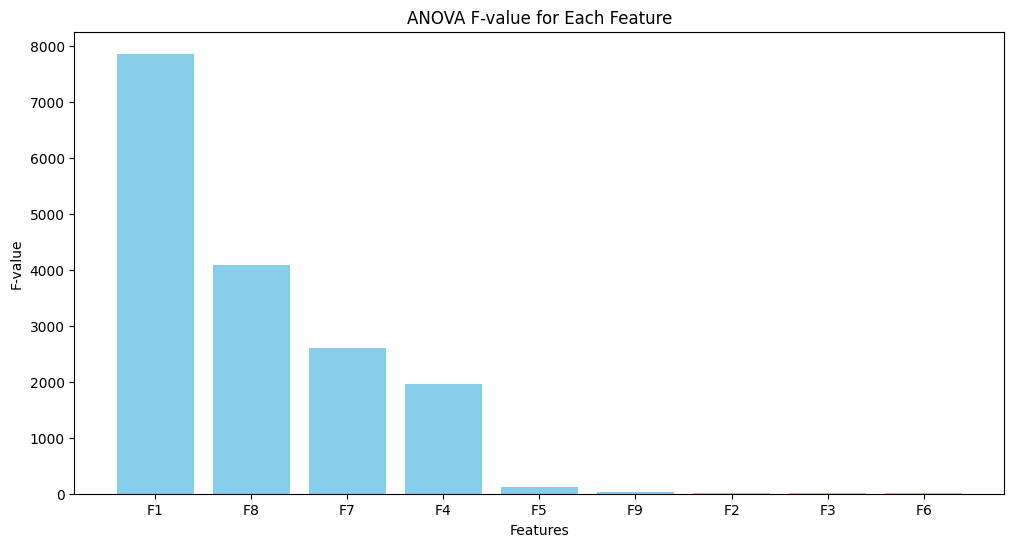

                                            headline  clickbait  F1  F4  F7  \
0                                 Should I Get Bings       True   0   0   0   
1      Which TV Female Friend Group Do You Belong In       True   0   0   0   
2  The New "Star Wars: The Force Awakens" Trailer...       True   0   2   0   
3  This Vine Of New York On "Celebrity Big Brothe...       True   0   2   0   
4  A Couple Did A Stunning Photo Shoot With Their...       True   0   0   0   

   F8  
0   4  
1   9  
2  14  
3  12  
4  18  


In [16]:
from sklearn.feature_selection import f_classif
import numpy as np
import matplotlib.pyplot as plt

# Extract the feature columns
feature_columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']
X = dataset[feature_columns]
y = dataset['clickbait']

# Perform ANOVA
F_values, p_values = f_classif(X, y)

# Create a DataFrame to display the F-values
anova_results = pd.DataFrame({'Feature': feature_columns, 'F_value': F_values})
anova_results = anova_results.sort_values(by='F_value', ascending=False)

# Plot the F-values
plt.figure(figsize=(12, 6))
plt.bar(anova_results['Feature'], anova_results['F_value'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('F-value')
plt.title('ANOVA F-value for Each Feature')
plt.show()

# Identify features with the five lowest F-values
features_to_remove = anova_results.nsmallest(5, 'F_value')['Feature'].tolist()

# Remove the identified features from the dataset
dataset = dataset.drop(columns=features_to_remove)

# Display the updated dataset with important features
print(dataset.head())

In [17]:
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, Input, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
max_words = 10000
max_len = 100
embedding_dim = 100

# Tokenizer erstellen und auf Daten fitten
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dataset['headline'])

# Daten vorbereiten
sequences = tokenizer.texts_to_sequences(dataset['headline'])
padded = pad_sequences(sequences, maxlen=max_len)

# Modell definieren
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim)(input_layer)
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
lstm_layer = LSTM(128)(embedding_layer)
concatenated_layer = Concatenate()([pooling_layer, lstm_layer])
dense_layer = Dense(64, activation='relu')(concatenated_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell trainieren
model.fit(padded, dataset['clickbait'], epochs=5, batch_size=32, validation_split=0.2)

# Modell evaluieren
loss, accuracy = model.evaluate(padded, dataset['clickbait'])
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.9063 - loss: 0.1982 - val_accuracy: 0.9731 - val_loss: 0.0816
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 64s 80ms/step - accuracy: 0.9934 - loss: 0.0188 - val_accuracy: 0.9800 - val_loss: 0.0567
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9595 - val_loss: 0.1792
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9998 - loss: 8.6221e-04 - val_accuracy: 0.9347 - val_loss: 0.3336
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9994 - loss: 0.0012 - val_accuracy: 0.9655 - val_loss: 0.1922
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9992 - loss: 0.0039
Loss: 0.038499075919389725, Accuracy: 0.993093729019165
